In [35]:
# basic libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array

In [36]:
from keras.models import load_model
model_enc_dec_cnn = load_model('test_1100_ver/weights-improvement-000004-0.010304.hdf5')

In [37]:
data_ver=pd.read_csv("Data/combined_data_ver.csv")
data_ver = data_ver.drop('Unnamed: 0', axis=1)
data_ver.head()

,Power_100_disc,Power_100_cont,Power_200_disc,Power_200_cont,Power_300_disc,Power_300_cont,Power_400_disc,Power_400_cont,Power_500_disc,Power_500_cont,Power_600_disc,Power_600_cont,Power_700_disc,Power_700_cont,Power_800_disc,Power_800_cont,Power_900_disc,Power_900_cont,Power_1000_disc,Power_1000_cont
0,1.902,0.000,3.321,0.99,1.61,3.912,0.012,6.596,0.504,1.176,0.086,3.753000,0.162,2.975,0.60,0.912000,0.233000,2.360,3.915000,7.248000
1,1.902,0.000,3.321,0.99,1.61,3.912,0.012,6.596,0.504,1.176,0.086,3.753000,0.162,2.975,0.60,0.912000,0.233000,2.360,3.915000,7.248000
2,2.364,2.272,6.030,0.99,2.34,2.934,0.012,3.104,0.504,1.176,1.470,8.757001,0.998,2.975,0.60,34.655998,0.676000,6.372,4.455000,7.248000
3,2.364,2.272,6.030,0.90,2.34,2.934,0.186,3.104,1.728,6.664,1.470,8.757001,0.998,9.350,3.56,34.655998,0.676000,6.372,4.455000,36.239998
4,5.122,2.272,12.730,0.90,2.34,2.934,0.186,3.104,1.728,6.664,20.580,8.757001,11.976,9.350,3.56,34.655998,22.307999,6.372,14.849999,36.239998


In [38]:
from sklearn.preprocessing import MinMaxScaler
power_list = [i for i in data_ver.columns]
scaler = MinMaxScaler()

perc=0.95

train_size = int(len(data_ver) * perc)
test_size = len(data_ver) - train_size

df_train = data_ver[0:train_size]
df_test = data_ver[train_size:len(data_ver)]

# scaled_train = scaler.fit_transform(df_train[power_list])
# scaled_test = scaler.transform(df_test[power_list])

scaled_train_and_test = scaler.fit_transform(data_ver[power_list])
scaled_train = scaled_train_and_test[0:train_size]
scaled_test = scaled_train_and_test[train_size:len(data_ver)]

print(len(scaled_train))
print(len(scaled_test))

23750
1250


In [39]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [40]:
LOOK_BACK=1100
FORECAST_RANGE=20

## making the look_back according to the main frequency since the data are kindly periodic

n_features=len(power_list)

X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22631, 1100, 20)
(22631, 20, 20)
(131, 1100, 20)
(131, 20, 20)


In [41]:
print(power_list)

['Power_100_disc', 'Power_100_cont', 'Power_200_disc', 'Power_200_cont', 'Power_300_disc', 'Power_300_cont', 'Power_400_disc', 'Power_400_cont', 'Power_500_disc', 'Power_500_cont', 'Power_600_disc', 'Power_600_cont', 'Power_700_disc', 'Power_700_cont', 'Power_800_disc', 'Power_800_cont', 'Power_900_disc', 'Power_900_cont', 'Power_1000_disc', 'Power_1000_cont']


In [42]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [43]:
# y_test_pred = model_enc_dec_cnn.predict(X_test)

# # reshape the predictions and test set
# y_test_pred = y_test_pred.reshape(-1, y_test_pred.shape[-1])
# y_test = y_test.reshape(-1, y_test.shape[-1])

# #inverse the scaling
# y_test_pred = scaler.inverse_transform(y_test_pred)
# y_test = scaler.inverse_transform(y_test)

# # create a time array
# time = np.arange(y_test.shape[0])

# # plot the predicted vs actual values
# plt.plot(time, y_test, label='Actual', color='blue')
# plt.plot(time, y_test_pred, label='Predicted', color='red')
# plt.xlim([0, 100])
# plt.xlabel('Time')
# plt.ylabel('Power consumption')
# plt.title('Prediction vs Actual Power consumption')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.show()

5/5 [==============================] - 2s 194ms/step
10.79431438446045
6.322280406951904
10.691837310791016
9.199261665344238
17.737357139587402
11.93600082397461
13.4799995422363
20.07200050354
12.616341590881348
17.3851900100708
22.404651641845703
31.5679988861084
33.92686653137207
26.273000717163
29.80345344543457
23.46712303161621
13.596362113952637
44.1599998474121
44.8399963378906
25.65976333618164


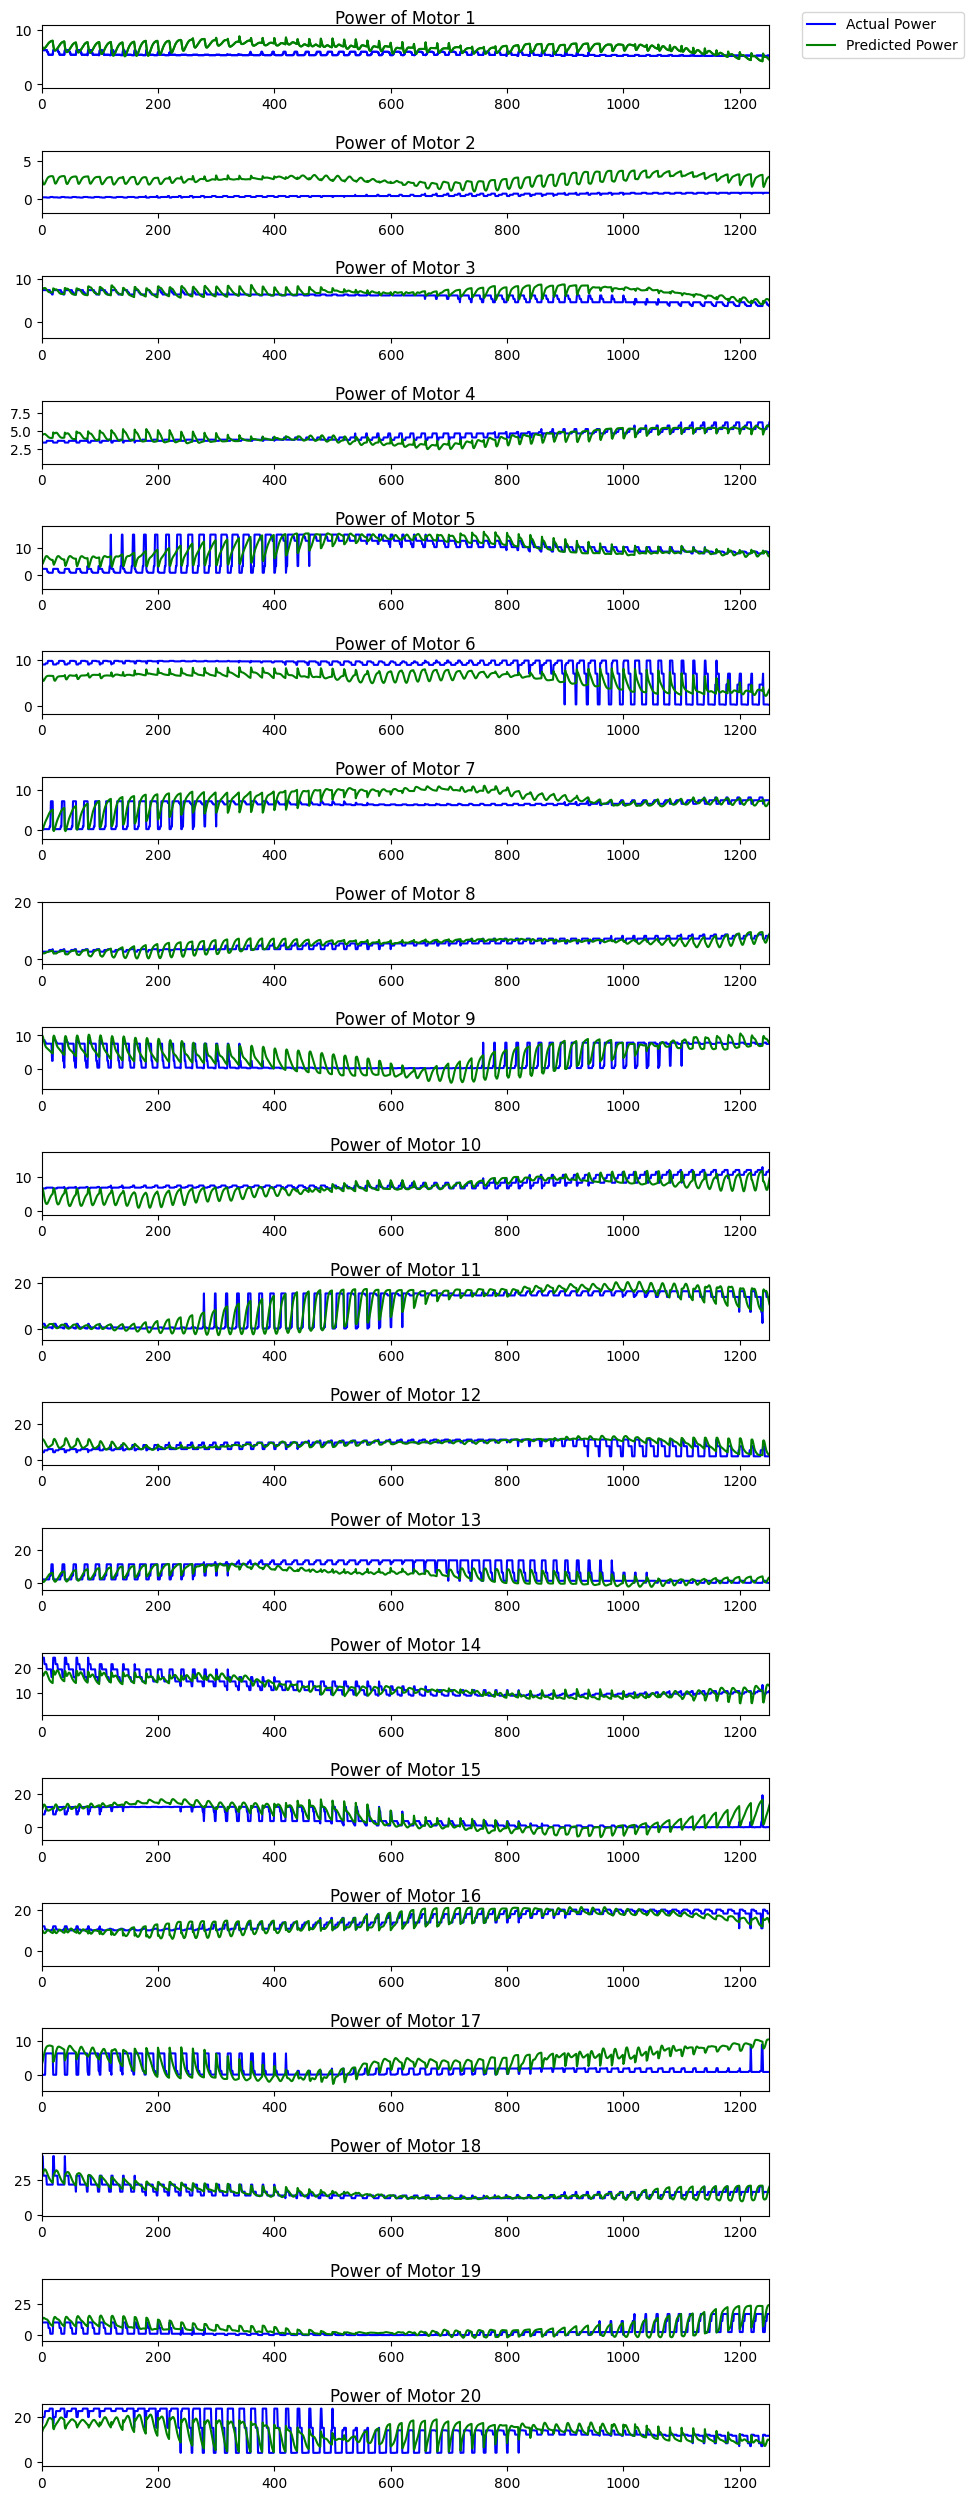

In [44]:
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
yhat = model_enc_dec_cnn.predict(X_test)
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, yhat.shape[-1]))


fig, ax = plt.subplots(n_features, 1, figsize=(8, 25))
fig.tight_layout()
plt.subplots_adjust(hspace=1)

for i in range(n_features):
    ax[i].plot(y_test_inverse[:, i], label='Actual Power', color='blue')
    ax[i].plot(yhat_inverse[:, i], label='Predicted Power', color='green')
    print(max(max(y_test_inverse[:, i]), max(yhat_inverse[:, i]))+2)
    ax[i].set_ylim([min(min(y_test_inverse[:, i]), min(yhat_inverse[:, i]))-2, max(max(y_test_inverse[:, i]), max(yhat_inverse[:, i]))+2])
    ax[i].set_title("Power of Motor {}".format(i+1), y=0.9)
    ax[i].set_xlim([0, 1250])
    

# actual_lines = [ax[i].plot(y_test_inverse[:, i], label='Actual Power')[0] for i in range(n_features)]
# predicted_lines = [ax[i].plot(yhat_inverse[:, i], label='Predicted Power')[0] for i in range(n_features)]
# fig.legend(actual_lines + predicted_lines, ['Actual Power']*n_features + ['Predicted Power']*n_features,loc='upper left', bbox_to_anchor=(1, 1))

line1, = ax[0].plot(y_test_inverse[:, 0], label='Actual Power', color='blue')
line2, = ax[0].plot(yhat_inverse[:, 0], label='Predicted Power', color='green')
fig.legend([line1, line2], ['Actual Power', 'Predicted Power'],loc='upper left', bbox_to_anchor=(1, 1), ncol=1)


# line1, = ax[0].plot(y_test_inverse[:, 0], label='Actual Power')
# line2, = ax[0].plot(yhat_inverse[:, 0], label='Predicted Power')
# fig.legend([line1, line2], ['Actual Power', 'Predicted Power'],loc='upper left', bbox_to_anchor=(1, 1))

# fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

5/5 [==============================] - 1s 175ms/step


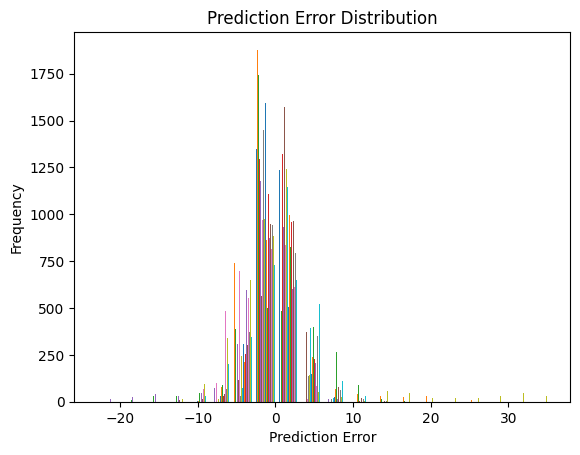

In [45]:
# predict the test set
y_test_pred = model_enc_dec_cnn.predict(X_test)

# reshape the predictions and test set
y_test_pred = y_test_pred.reshape(-1, y_test_pred.shape[-1])
y_test = y_test.reshape(-1, y_test.shape[-1])

#inverse the scaling
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test)

# Prediction over distribution

# calculate the prediction error
error = y_test - y_test_pred

# plot the error distribution
plt.hist(error, bins=20)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


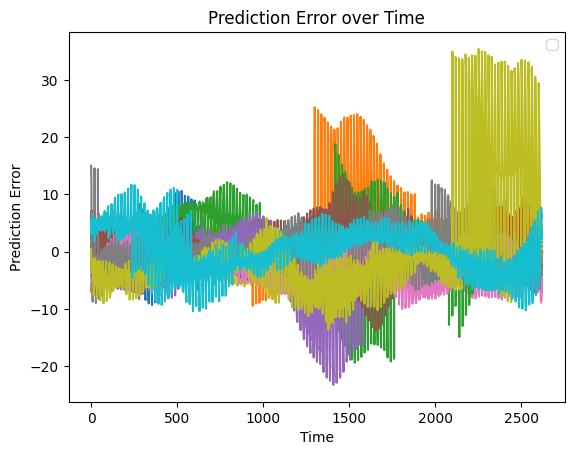

In [46]:
# Prediction error over time:

# create a time array
time = np.arange(y_test.shape[0])

# calculate the prediction error
error = y_test - y_test_pred

# plot the error over time
plt.plot(time, error)
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.title('Prediction Error over Time')
plt.legend()
plt.show()

In [47]:
# # Prediction error over input feature:


# # loop through each feature
# for i in range(X_test.shape[1]):
#     # calculate the error for the feature
#     feature_error = y_test[:,i] - y_test_pred[:,i]
#     # plot the error for the feature
#     plt.plot(time, feature_error, label='Feature '+str(i))

# plt.xlabel('Time')
# plt.ylabel('Prediction Error')
# plt.title('Prediction Error over Input Feature')
# plt.legend()
# plt.show()

5/5 [==============================] - 1s 158ms/step
Mean Squared Error:  168956.02575126942
Mean Absolute Error:  270.71479757813046
Mean Absolute Percentage Error:  229152015269513.66


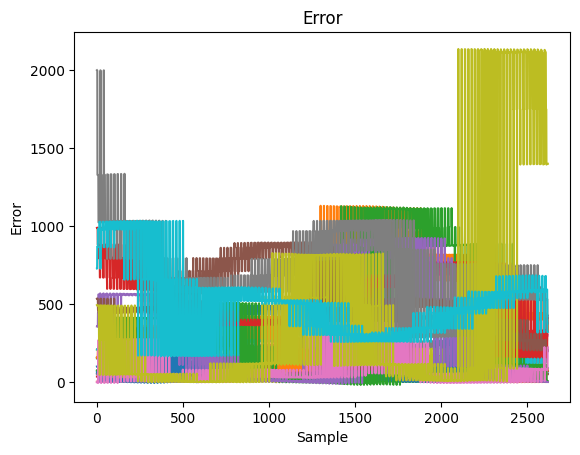

1/1 [==============================] - 0s 44ms/step


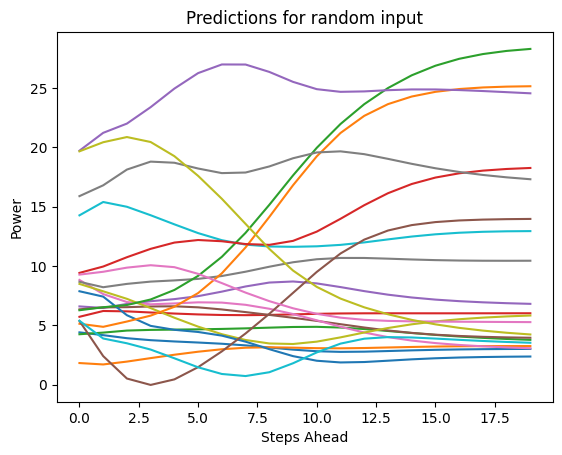

In [48]:
# Get predictions for the test set
yhat = model_enc_dec_cnn.predict(X_test)

# Inverse transform the predictions
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, yhat.shape[-1]))

# Inverse transform the test set
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))

# # Plot the predictions
# plt.plot(yhat_inverse)
# plt.show()

# Evaluate the forecast
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mse = mean_squared_error(y_test_inverse, yhat_inverse)
print("Mean Squared Error: ", mse)

mae = mean_absolute_error(y_test_inverse, yhat_inverse)
print("Mean Absolute Error: ", mae)

mape = mean_absolute_percentage_error(y_test_inverse, yhat_inverse)
print("Mean Absolute Percentage Error: ", mape)


# Calculating the errors
error = y_test_inverse - yhat_inverse

# Plotting the errors
plt.plot(error)
plt.title("Error")
plt.xlabel("Sample")
plt.ylabel("Error")
plt.show()

# Selecting a random input
random_input = np.random.randint(X_test.shape[0])
X_input = X_test[random_input]
X_input = X_input.reshape(1, LOOK_BACK, n_features)

# Generating predictions
yhat_random = model_enc_dec_cnn.predict(X_input)
yhat_random_inverse = scaler.inverse_transform(yhat_random.reshape(-1, yhat_random.shape[-1]))

# Plotting the predictions
plt.plot(yhat_random_inverse)
plt.title("Predictions for random input")
plt.xlabel("Steps Ahead")
plt.ylabel("Power")
plt.show()
